In [1]:
import tensorflow as tf

In [ ]:
# gpu_devices = tf.config.experimental.list_physical_devices("GPU")
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [2]:
import indl
from pathlib import Path
import sys
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from itertools import cycle
from filterpy.kalman.UKF import UnscentedKalmanFilter as ukf
from filterpy.kalman import MerweScaledSigmaPoints


import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)

from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    

load_kwargs = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_ul = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, -1),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

model_kwargs = dict(
    filt=8,
    kernLength=20,
    ds_rate=5,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=32
)
model_kwargs1 = dict(
    filt=16,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs2 = dict(
    filt=32,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 150
EPOCHS2 = 100
LABEL_SMOOTHING = 0.2

from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer

def make_model(
    _input,
    num_classes,
    filt=32,
    kernLength=16,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.1,
    activation='tanh',
    l1_reg=0.010, l2_reg=0.010,
    norm_rate=0.25,
    latent_dim=32,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
#     if _input.shape[2] < 10:
#         kernLength = 4
#         filt = 4
#         ds_rate = 4
#     elif _input.shape[2] < 20:
#         kernLength = 8
#         ds_rate = 8
#     elif _input.shape[2] < 30:
#         kernLength = 16
    
#     input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
#     if len(input_shape) < 4:
#         input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
#     _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv1D(filt, kernLength, strides=1, padding='valid', dilation_rate=1, groups=1,
                                activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None,
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                                bias_constraint=None)(inputs)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)


def kfold_pred(sess_id,X_rates,Y_class,name, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
#         randseed = 12345
#         random.seed(randseed)
#         np.random.seed(randseed)
#         tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'{name}_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Accuracy: {accuracy}%\n\n")
    
    return history, accuracy, pred_y, true_y

Data directory found. Skipping download.


# Stream Monkey Data

## Classification

In [33]:
# TODO: Stream via LSL

In [30]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1"
print(f"\nImporting session {sess_id}")
x_tmp, y_tmp, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
y_tmp = np.array(y_tmp).flatten()
shuffler = np.random.permutation(len(x_tmp))
X_rates = x_tmp[shuffler]
Y = y_tmp[shuffler]
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
times = np.array(ax_info['timestamps'])
target = np.array(ax_info['instance_data']['TargetRule'])
color = np.array(ax_info['instance_data']['CueColour'])
print(X_rates.shape, Y.shape, np.unique(Y, return_counts=True))
print(times.shape, target.shape, color.shape)
print(np.argwhere(times==0), np.argwhere(times==0.25), np.argwhere(times==1.25))


Importing session sra3_1_j_050_00_v1
(663, 32, 207) (663,) (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 61,  48, 115,  62,  92, 142,  82,  61], dtype=int64))
(207,) (663,) (663,)
[[25]] [[50]] [[150]]


In [31]:
EPOCHS = 200
X = X_rates[:150]
y = Y_class[:150]

ds_train = tf.data.Dataset.from_tensor_slices((X[:100], y[:100]))
ds_valid = tf.data.Dataset.from_tensor_slices((X[100:], y[100:]))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)

ds_train = ds_train.shuffle(100 + 1)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)


model = make_model(X, y.shape[-1])
optim = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS,
                 verbose=1,
                 validation_data=ds_valid)

Epoch 1/200
6/6 [==============================] - 1s 155ms/step - loss: 2.3100 - accuracy: 0.6146 - val_loss: 2.1947 - val_accuracy: 0.6200
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 1.7109 - accuracy: 0.8125 - val_loss: 1.8160 - val_accuracy: 0.8600
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 1.3887 - accuracy: 0.9583 - val_loss: 1.6282 - val_accuracy: 0.8600
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 1.2264 - accuracy: 0.9688 - val_loss: 1.4750 - val_accuracy: 0.8600
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 1.1474 - accuracy: 0.9792 - val_loss: 1.4906 - val_accuracy: 0.8000
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 1.0925 - accuracy: 0.9792 - val_loss: 1.3942 - val_accuracy: 0.7800
Epoch 7/200
6/6 [==============================] - 0s 6ms/step - loss: 1.0242 - accuracy: 0.9896 - val_loss: 1.3119 - val_accuracy: 0.8600
Epoch 8/200
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.8403 - accuracy: 1.0000 - val_loss: 1.1149 - val_accuracy: 0.8200
Epoch 118/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8316 - accuracy: 1.0000 - val_loss: 1.1988 - val_accuracy: 0.7800
Epoch 119/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8254 - accuracy: 1.0000 - val_loss: 1.1687 - val_accuracy: 0.7800
Epoch 120/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8257 - accuracy: 1.0000 - val_loss: 1.1965 - val_accuracy: 0.7400
Epoch 121/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8224 - accuracy: 1.0000 - val_loss: 1.1971 - val_accuracy: 0.7400
Epoch 122/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8228 - accuracy: 1.0000 - val_loss: 1.2024 - val_accuracy: 0.7600
Epoch 123/200
6/6 [==============================] - 0s 5ms/step - loss: 0.8235 - accuracy: 1.0000 - val_loss: 1.2542 - val_accuracy: 0.7400
Epoch 124/200
6/6 [========

In [32]:
i = 0
t = 150
EPOCHS = 50
X_t = np.reshape(X[-1], [1, X.shape[1], X.shape[2]])
y_t = np.reshape(y[-1], [1, y.shape[1]])
X = X_rates[:150]
y = Y_class[:150]
while t < 662:
    X_new = np.reshape(X_rates[t], [1, X_rates.shape[1], X_rates.shape[2]])
    y_new = Y[t]
    t = t + 1
    
    pred = np.argmax(model.predict(X_new))
    print(f"Predicted: {pred}, True: {y_new}")
    X_t = np.concatenate((X_t, X_new), axis=0)
    Y_new = np.reshape(tf.keras.utils.to_categorical(y_new, num_classes=8), [1, 8])
    y_t = np.concatenate((y_t, Y_new), axis=0)
    i = i + 1
    if i == 50:
        print("Updating...")
        X = np.concatenate((X[-100:], X_t), axis=0)
        y = np.concatenate((y[-100:], y_t), axis=0)
        X_t = np.reshape(X[-1], [1, X.shape[1], X.shape[2]])
        y_t = np.reshape(y[-1], [1, y.shape[1]])
        
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        ds_train = tf.data.Dataset.from_tensor_slices((X[:-50], y[:-50]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X[-50:], y[-50:]))
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_train = ds_train.shuffle(X.shape[0] - 50 + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)
        model.fit(x=ds_train, epochs=EPOCHS, verbose=0, validation_data=ds_valid)
        print("Model Updated.")
        i = 0

Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 6, True: 6
Predicted: 7, True: 7
Predicted: 7, True: 4
Predicted: 4, True: 4
Predicted: 1, True: 5
Predicted: 7, True: 7
Predicted: 0, True: 0
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 2, True: 6
Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 2, True: 6
Predicted: 4, True: 4
Predicted: 4, True: 4
Predicted: 1, True: 1
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 0, True: 0
Predicted: 5, True: 5
Predicted: 7, True: 7
Predicted: 0, True: 0
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 7, True: 6
Predicted: 1, True: 1
Predicted: 2, True: 2
Predicted: 0, True: 0
Predicted: 5, True: 5
Predicted: 7, True: 7
Predicted: 7, True: 4
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 7, True: 6
Predicted: 1, True: 1
Predicted: 6, True: 3
Predicted:

Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 4, True: 4
Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 6, True: 6
Predicted: 1, True: 1
Predicted: 4, True: 4
Predicted: 4, True: 4
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 7, True: 7
Predicted: 1, True: 5
Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 5, True: 5
Predicted: 0, True: 0
Predicted: 2, True: 2
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 6, True: 6
Predicted: 6, True: 6
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 5, True: 5
Predicted: 5, True: 5
Predicted: 3, True: 3
Predicted: 1, True: 1
Updating...
Model Updated.
Predicted: 5, True: 5
Predicted: 4, True: 4
Predicted: 7, True: 7
Predicted: 4, True: 4
Predicted: 4, True: 4
Predicted: 5, True: 5
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 5, True: 5
Predicted: 5, True: 5
Predicted: 6, True: 6
Predicted: 2, True: 2
Predi

## Regression

In [5]:
SESS_IDX = 0          # Index of recording session we will use. 0:8
BIN_DURATION = 0.250  # Width of window used to bin spikes, in seconds
N_TAPS = 2            # Number of bins of history used in a sequence.
P_TRAIN = 0.8         # Proportion of data used for training.
BATCH_SIZE = 32       # Number of sequences in each training step.
P_DROPOUT = 0.05      # Proportion of units to set to 0 on each step.
N_RNN_UNITS = 64      # Size of RNN output (state)
L2_REG = 0.000017       # Parameter regularization strength.
STATEFUL = False      # Whether or not to keep state between sequences (True is not tested)
EPOCHS = 10 

In [3]:
def load_joeyo_reaching(data_path, sess_id, x_chunk='lfps', zscore=False):
    """
    Load data from the joeyo dataset.
    :param data_path: path to joeyo data dir (i.e., parent of 'converted'
    :param sess_id: 'indy_2016' + one of '0921_01', '0927_04', '0927_06', '0930_02', '0930_05' '1005_06' '1006_02'
    :param x_chunk: 'lfps' (default), 'mu_rates', 'su_rates', 'spiketimes', or 'mu_spiketimes'.
    :param zscore: Set to True to z-score data before returning. default: False
    :return: X, Y, X_ax_info, Y_ax_info
    """
    file_path = Path(data_path) / 'converted' / (sess_id + '.h5')
    chunks = from_neuropype_h5(file_path)
    chunk_names = [_[0] for _ in chunks]

    Y_chunk = chunks[chunk_names.index('behav')][1]
    Y_ax_types = [_['type'] for _ in Y_chunk['axes']]
    Y_ax_info = {'channel_names': Y_chunk['axes'][Y_ax_types.index('space')]['names'],
                 'timestamps': Y_chunk['axes'][Y_ax_types.index('time')]['times'],
                 'fs': Y_chunk['axes'][Y_ax_types.index('time')]['nominal_rate']}

    X_chunk = chunks[chunk_names.index(x_chunk)][1]
    X_ax_types = [_['type'] for _ in X_chunk['axes']]
    X_ax_info = {'channel_names': X_chunk['axes'][X_ax_types.index('space')]['names'],
                 'timestamps': X_chunk['axes'][X_ax_types.index('time')]['times'],
                 'fs': X_chunk['axes'][X_ax_types.index('time')]['nominal_rate']}

    if zscore:
        X_chunk['data'] = (X_chunk['data'] - np.mean(X_chunk['data'], axis=1, keepdims=True))\
                          / np.std(X_chunk['data'], axis=1, keepdims=True)
        Y_chunk['data'] = (Y_chunk['data'] - np.mean(Y_chunk['data'], axis=1, keepdims=True)) \
                          / np.std(Y_chunk['data'], axis=1, keepdims=True)

    return X_chunk['data'], Y_chunk['data'], X_ax_info, Y_ax_info

def load_dat_with_vel_accel(datadir, sess_idx):
    BEHAV_CHANS = ['CursorX', 'CursorY']
    sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                       '61006_02', '60124_01', '60127_03']]
    X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_names[sess_idx], x_chunk='mu_spiketimes')

    # Slice Y to only keep required behaviour data (cursor position)
    b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , BEHAV_CHANS)
    Y = Y[b_keep_y_chans, :]
    Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

    # Calculate discrete derivative and double-derivative to get velocity and acceleration.
    vel = np.diff(Y, axis=1)
    vel = np.concatenate((vel[:, 0][:, None], vel), axis=1)  # Assume velocity was constant across the first two samples.
    accel = np.concatenate(([[0], [0]], np.diff(vel, axis=1)), axis=1)  # Assume accel was 0 in the first sample.
    Y = np.concatenate((Y, vel, accel), axis=0)
    Y_ax_info['channel_names'] += ['VelX', 'VelY', 'AccX', 'AccY']
    
    return X, Y, X_ax_info, Y_ax_info

def bin_spike_times(X, X_ax_info, bin_duration=0.256, bin_step_dur=0.004):
    bin_samples = int(np.ceil(bin_duration * X_ax_info['fs']))
    bin_starts_t = np.arange(X_ax_info['timestamps'][0], X_ax_info['timestamps'][-1], bin_step_dur)
    bin_starts_idx = np.searchsorted(X_ax_info['timestamps'], bin_starts_t)
    
    # Only keep bins that do not extend beyond the data limit.
    b_full_bins = bin_starts_idx <= (X.shape[-1] - bin_samples)
    bin_starts_idx = bin_starts_idx[b_full_bins]
    bin_starts_t = bin_starts_t[b_full_bins]
    
    # The next chunk of code counts the number of spikes in each bin.
    # Create array of indices to reslice the raster data
    bin_ix = np.arange(bin_samples)[:, None] + bin_starts_idx[None, :]
    # Create buffer to hold the dense raster data
    _temp = np.zeros(X[0].shape, dtype=bool)
    # Create output variable to hold spike counts per bin
    _X = np.zeros((len(bin_starts_idx), X.shape[0]), dtype=np.int32)
    for chan_ix in range(X.shape[0]):
        _X[:, chan_ix] = np.sum(X[chan_ix].toarray(out=_temp)[0][bin_ix], axis=0)
    _X = _X / bin_duration

    return _X.astype(np.float32), bin_starts_t, bin_samples

def get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=3):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']
    bin_stops_t = bin_stops_t[(N_TAPS-1):]

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(len(bin_stops_t), N_TAPS, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    
    b_keep_y = Y_ax_info['timestamps'] > bin_stops_t[0]
    n_extra_y = np.sum(b_keep_y) - len(bin_stops_t)
    if n_extra_y > 0:
        b_keep_y[-n_extra_y] = False
    _Y = Y[:, b_keep_y].T
    
    _X_tapped = _X_tapped[:_Y.shape[0], :, :]
    bin_stops_t = bin_stops_t[:_Y.shape[0]]
    
    return _X_tapped, _Y.astype(np.float32), bin_stops_t

def get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(len(bin_stops_t), 1, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    
    b_keep_y = Y_ax_info['timestamps'] > bin_stops_t[0]
    n_extra_y = np.sum(b_keep_y) - len(bin_stops_t)
    if n_extra_y > 0:
        b_keep_y[-n_extra_y] = False
    _Y = Y[:, b_keep_y].T
    
    _X_tapped = _X_tapped[:_Y.shape[0], :, :]
    bin_stops_t = bin_stops_t[:_Y.shape[0]]
    
    return _X_tapped, _Y.astype(np.float32), bin_stops_t


def prepare_for_tensorflow(_X_tapped, _Y, p_train=0.8, batch_size=32, stateful=False):
    if stateful:
        # If using stateful then we keep the sequences in order.
        valid_start = int(np.ceil(_X_tapped.shape[0] * p_train))
        X_train = _X_tapped[:valid_start]
        Y_train = _Y[:valid_start]
        X_valid = _X_tapped[valid_start:]
        Y_valid = _Y[valid_start:]
    else:
        # If not using stateful then we shuffle sequences.
        from sklearn.model_selection import train_test_split
        X_train, X_valid, Y_train, Y_valid = train_test_split(_X_tapped, _Y, train_size=p_train)

    # Get mean and std of training data for z-scoring
    _X_mean = np.nanmean(X_train[:, 0, :], axis=0)[None, None, :]
    _X_std = np.nanstd(X_train[:, 0, :], axis=0)[None, None, :]
    _Y_mean = np.nanmean(Y_train, axis=0, keepdims=True)
    _Y_std = np.nanstd(Y_train, axis=0, keepdims=True)

    # Z-score both training and testing data. For Y, only center it.
    X_train = (X_train - _X_mean) / _X_std
    X_valid = (X_valid - _X_mean) / _X_std
    Y_train = (Y_train - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.
    Y_valid = (Y_valid - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.
    
    # Also transform all of _X_tapped and _Y for plotting.
    _X_tapped = (_X_tapped - _X_mean) / _X_std
    _Y = (_Y - _Y_mean)

    ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

    if not stateful:
        ds_train = ds_train.shuffle(int(_X_tapped.shape[0] * P_TRAIN) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=True)
    
    return _X_tapped, _Y, ds_train, ds_valid

In [6]:
X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(data_path, SESS_IDX)
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))
_X_tapped, _Y, bin_stops_t = get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=N_TAPS)
print(_X.shape,_X_tapped.shape, _Y.shape)

(89975, 88) (89974, 2, 88) (89974, 6)


In [20]:
X.shape

(88, 351707)

KeyboardInterrupt: 

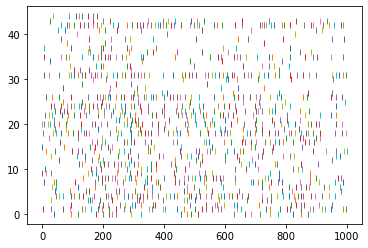

In [24]:
plt.figure()
for y in range(88):
    for x in range(1000):
        if X[y,x]:
            pl.plot(x, y, '|')
            display.clear_output(wait=True)
            display.display(pl.gcf())

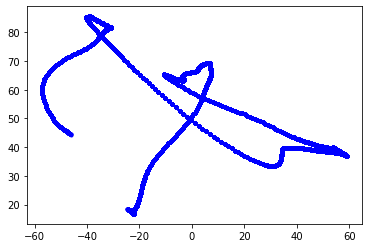

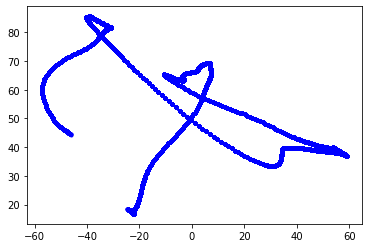

In [25]:
%matplotlib inline
import time
import matplotlib.pylab as pl
from IPython import display

t = 0
while t < 1000:
    pl.plot(_Y[t:t+50,0], _Y[t:t+50,1],'.-', color='blue')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    t = t+1
#     if t%5000 == 0:
#         plt.clf()

In [6]:
def make_regression_model(
    _input,
    output_shape,
    n_rnn_units=100,
    p_dropout=0.3,
    l2_reg=0.001,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
#     if _input.shape[2] < 10:
#         kernLength = 4
#         filt = 4
#         ds_rate = 4
#     elif _input.shape[2] < 20:
#         kernLength = 8
#         ds_rate = 8
#     elif _input.shape[2] < 30:
#         kernLength = 16
    
#     input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
#     if len(input_shape) < 4:
#         input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
#     _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
#     _y = tf.keras.layers.Dense(64, activation='linear')(inputs)
#     _y = tf.keras.layers.Dense(32, activation='tanh')(inputs)
#     _y = tf.keras.layers.Conv1D(64, 3, strides=1, padding='valid', dilation_rate=1, groups=1,
#                                 activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#                                 bias_initializer='zeros', kernel_regularizer=None,
#                                 bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
#                                 bias_constraint=None)(_y)
#     _y = tf.keras.layers.Dense(64, activation='linear')(_y)
    _y = tf.keras.layers.LSTM(n_rnn_units, dropout=p_dropout, recurrent_dropout=0,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False, stateful=False)(inputs)
#     _y = tf.keras.layers.Dropout(P_DROPOUT)(_y)
    
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(_y)    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [7]:
EPOCHS = 20
X = _X_tapped[:5000]
y = _Y[:5000]
X, y, ds_train, ds_valid = prepare_for_tensorflow(X, y, p_train=P_TRAIN, batch_size=BATCH_SIZE)

model = make_regression_model(X, y.shape[-1],n_rnn_units=N_RNN_UNITS,p_dropout=P_DROPOUT,l2_reg=L2_REG)
optim = tf.keras.optimizers.RMSprop(learning_rate=0.01)
loss_obj = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optim, loss=loss_obj, metrics=[tf.keras.metrics.MeanSquaredError()])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 88)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                39168     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 39,558
Trainable params: 39,558
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

Epoch 1/20
125/125 [==============================] - 0s 3ms/step - loss: 94.8632 - mean_squared_error: 94.8373 - val_loss: 9.0385 - val_mean_squared_error: 8.9976
Epoch 2/20
125/125 [==============================] - 0s 879us/step - loss: 5.6927 - mean_squared_error: 5.6462 - val_loss: 3.0915 - val_mean_squared_error: 3.0403
Epoch 3/20
125/125 [==============================] - 0s 830us/step - loss: 2.3611 - mean_squared_error: 2.3052 - val_loss: 1.5692 - val_mean_squared_error: 1.5091
Epoch 4/20
125/125 [==============================] - 0s 907us/step - loss: 2.1163 - mean_squared_error: 2.0524 - val_loss: 0.8619 - val_mean_squared_error: 0.7938
Epoch 5/20
125/125 [==============================] - 0s 860us/step - loss: 1.2213 - mean_squared_error: 1.1502 - val_loss: 1.0348 - val_mean_squared_error: 0.9601
Epoch 6/20
125/125 [==============================] - 0s 925us/step - loss: 1.2100 - mean_squared_error: 1.1316 - val_loss: 0.7580 - val_mean_squared_error: 0.6769
Epoch 7/20
125/1

In [9]:
def make_model(input_shape, output_shape,
               n_rnn_units=100,
               p_dropout=0.3,
               l2_reg=0.001,
               stateful=False):
    # Note: batch_shape, not shape, if using stateful
    if stateful:
        inputs = tf.keras.layers.Input(batch_shape=input_shape)
    else:
        inputs = tf.keras.layers.Input(shape=input_shape)
    _y = tf.keras.layers.LSTM(n_rnn_units, dropout=p_dropout, recurrent_dropout=0,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False, stateful=stateful)(inputs)
    if p_dropout > 0.0:
        _y = tf.keras.layers.Dropout(p_dropout)(_y)
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(_y)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return model

input_shape = _X_tapped.shape[1:]
if STATEFUL:
    input_shape = (BATCH_SIZE,) + input_shape
    
model = make_model(input_shape, _Y.shape[1],
                   n_rnn_units=N_RNN_UNITS,
                   p_dropout=P_DROPOUT,
                   l2_reg=L2_REG,
                   stateful=STATEFUL)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 88)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                39168     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 39,558
Trainable params: 39,558
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

Epoch 1/20
125/125 [==============================] - 1s 4ms/step - loss: 299.4078 - val_loss: 263.8298
Epoch 2/20
125/125 [==============================] - 0s 862us/step - loss: 228.2574 - val_loss: 192.7328
Epoch 3/20
125/125 [==============================] - 0s 838us/step - loss: 162.0878 - val_loss: 130.2256
Epoch 4/20
125/125 [==============================] - 0s 806us/step - loss: 107.5827 - val_loss: 83.3033
Epoch 5/20
125/125 [==============================] - 0s 909us/step - loss: 68.6955 - val_loss: 52.0748
Epoch 6/20
125/125 [==============================] - 0s 875us/step - loss: 43.7490 - val_loss: 32.0670
Epoch 7/20
125/125 [==============================] - 0s 846us/step - loss: 27.1479 - val_loss: 18.6431
Epoch 8/20
125/125 [==============================] - 0s 812us/step - loss: 16.0617 - val_loss: 10.2623
Epoch 9/20
125/125 [==============================] - 0s 910us/step - loss: 9.7367 - val_loss: 5.5605
Epoch 10/20
125/125 [==============================] - 0s 888

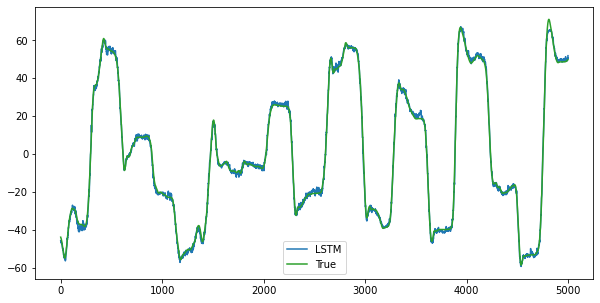

In [12]:
# X = _X_tapped[:5000]
# y = _Y[:5000]
pred = model.predict(X)
plt.figure(figsize=(10,5))
plt.plot(pred[:,0], color='tab:blue', label='LSTM')
plt.plot(y[:,0], color='tab:green', label='True')
plt.legend()

In [14]:
# For unscented we use the acceleration too
# Also the states and neural data are concatenated
X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(data_path, SESS_IDX)
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))
neural, states, bin_stops_t = get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1)
neural = np.squeeze(neural).T
training_size = 5000

# state = np.concatenate((states.T, neural))
state = states.T
state_train = state[:, :training_size]
state_test = state[:, training_size:]
neural_train = neural[:, :training_size]
neural_test = neural[:, training_size:]

dim_state = np.size(states, 1)
dim_neural = np.size(neural, 0)

time_step = 1 / X_ax_info['fs']

# Initializing the Kalman matrices
x1 = state_train[:, :-1]
x2 = state_train[:, 1:]
tmp1 = x2 @ x1.T
tmp2 = np.linalg.inv(x1 @ x1.T)
F = tmp1 @ tmp2

tmp1 = x2 - (F @ x1)
Q = (tmp1 @ tmp1.T) / (dim_state - 1)

tmp1 = neural_train @ state_train.T
tmp2 = np.linalg.inv(state_train @ state_train.T)
H = tmp1 @ tmp2

tmp1 = neural_train - (H @ state_train)
tmp2 = tmp1 @ tmp1.T
R = np.divide(tmp2, dim_state)

# The transition and observation functions for UKF
def transition(state, time_step = time_step):
    output = np.zeros_like(state)
    cursor = state
    output = F @ cursor
#     output[6:] = state[6:]
    return output


def observation (state):
    return H @ state[:6]
  
# Defining sigma points to pass onto UKF
points = MerweScaledSigmaPoints(np.size(state, 0), alpha=1., beta=2., kappa=0)

# Instantiating from UKF class
myukf = ukf(dim_x = dim_state, dim_z = dim_neural, dt = time_step, fx = transition, hx = observation, points = points)

# Initializing the UKF object
myukf.x = state[:, training_size]
myukf.R = R
myukf.Q = np.eye(dim_state)
myukf.Q[:np.size(Q, 0), :np.size(Q, 1)] = Q

# Looping through test data
rng = 3000

ukf_predict = np.zeros((dim_state, rng))
for i in range(rng):
    neural_in = neural[:, i + training_size]
    myukf.predict(dt=time_step)
    myukf.update(neural_in)
    ukf_predict[:, i] = myukf.x
    if (i-training_size) % 200 == 0:
        print('UKF - Step: ' + str(i) + ' out of ' + str(rng))
print('UKF Finished')

UKF - Step: 0 out of 3000
UKF - Step: 200 out of 3000
UKF - Step: 400 out of 3000
UKF - Step: 600 out of 3000
UKF - Step: 800 out of 3000
UKF - Step: 1000 out of 3000
UKF - Step: 1200 out of 3000
UKF - Step: 1400 out of 3000
UKF - Step: 1600 out of 3000
UKF - Step: 1800 out of 3000
UKF - Step: 2000 out of 3000
UKF - Step: 2200 out of 3000
UKF - Step: 2400 out of 3000
UKF - Step: 2600 out of 3000
UKF - Step: 2800 out of 3000
UKF Finished


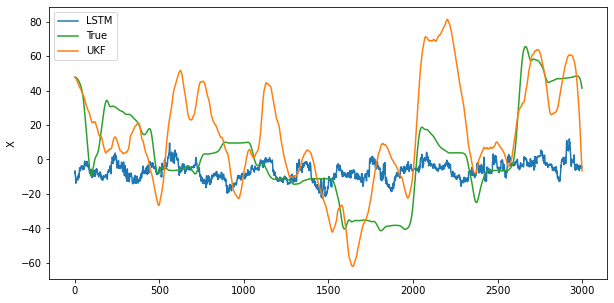

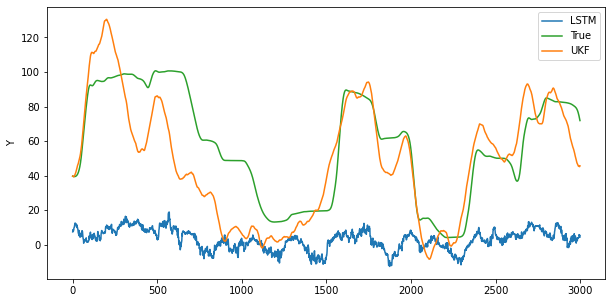

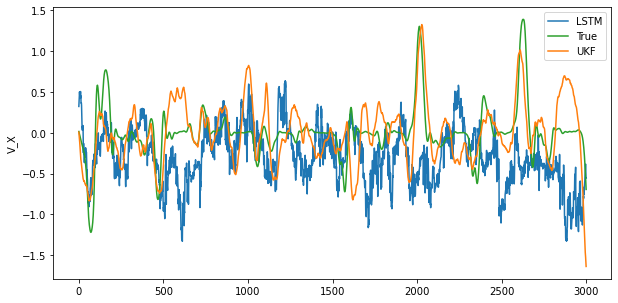

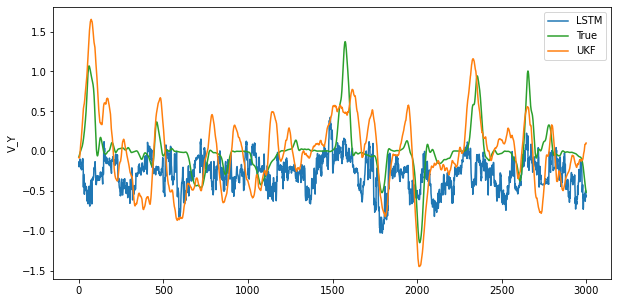

In [15]:
X = _X_tapped[training_size:training_size+3000]
y = _Y[training_size:training_size+3000]
pred = model.predict(X)
plt.figure(figsize=(10,5))
plt.plot(pred[:,0], color='tab:blue', label='LSTM')
plt.plot(y[:,0], color='tab:green', label='True')
plt.plot(ukf_predict[0, :], color='tab:orange',label='UKF')
plt.ylabel('X')
plt.legend()
plt.figure(figsize=(10,5))
plt.plot(pred[:,1], color='tab:blue', label='LSTM')
plt.plot(y[:,1], color='tab:green', label='True')
plt.plot(ukf_predict[1, :], color='tab:orange',label='UKF')
plt.ylabel('Y')
plt.legend()
plt.figure(figsize=(10,5))
plt.plot(pred[:,2], color='tab:blue', label='LSTM')
plt.plot(y[:,2], color='tab:green', label='True')
plt.plot(ukf_predict[2, :], color='tab:orange',label='UKF')
plt.ylabel('V_X')
plt.legend()
plt.figure(figsize=(10,5))
plt.plot(pred[:,3], color='tab:blue', label='LSTM')
plt.plot(y[:,3], color='tab:green', label='True')
plt.plot(ukf_predict[3, :], color='tab:orange',label='UKF')
plt.ylabel('V_Y')
plt.legend()

KeyboardInterrupt: 

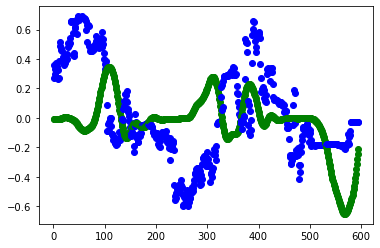

In [22]:
%matplotlib inline
import time
import matplotlib.pylab as pl
from IPython import display

i = 0
t = 15000
EPOCHS = 10
X_t = np.reshape(X[-1], [1, X.shape[1], X.shape[2]])
y_t = np.reshape(y[-1], [1, y.shape[1]])
X = _X_tapped[:15000]
y = _Y[:15000]
while t < 89800:
    X_new = np.reshape(_X_tapped[t], [1, _X_tapped.shape[1], _X_tapped.shape[2]])
    y_new = np.reshape(_Y[t], [1, _Y.shape[1]])
    t = t + 1
    
    X_t = np.concatenate((X_t, X_new), axis=0)
    y_t = np.concatenate((y_t, y_new), axis=0)
    
    pred = model.predict(X_t)
    pl.plot(t-15000,pred[-1,0], 'o', color='blue')
    pl.plot(t-15000,y_new[0,0], 'o', color='green')
    display.clear_output(wait=True)
    display.display(pl.gcf())
#     time.sleep(0.01)
    
    i = i + 1
#     if i == 500:
#         print("Updating...")
#         X = np.concatenate((X[-1000:], X_t), axis=0)
#         y = np.concatenate((y[-1000:], y_t), axis=0)
#         X_t = np.reshape(X[-1], [1, X.shape[1], X.shape[2]])
#         y_t = np.reshape(y[-1], [1, y.shape[1]])
        
#         X, y, ds_train, ds_valid = prepare_for_tensorflow(X, y, p_train=P_TRAIN, batch_size=BATCH_SIZE)
#         optim = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#         loss_obj = tf.keras.losses.MeanSquaredError()
#         model.compile(optimizer=optim, loss=loss_obj, metrics=[tf.keras.metrics.MeanSquaredError()])
#         model.fit(x=ds_train, epochs=EPOCHS, verbose=0, validation_data=ds_valid)
#         print("Model Updated.")
#         i = 0

In [69]:
y_new[0][0]

-0.15285589

In [47]:
class ManualKalmanFilter(object):
    def __init__(self, x, z):
        self.x = x
        self.z = z
        self.m = np.size(self.x, 0)
        self.n = np.size(self.z, 0)
        self.F = np.zeros((self.m, self.m))
        self.H = np.zeros((self.n, self.m))
        self.Q = np.zeros((self.m, self.m))
        self.R = np.zeros((self.n, self.n))
        self.xk_bar = np.zeros(self.m)
        self.pk_bar = np.zeros((self.m, self.m))
        self.P = np.eye(self.m)
        self.model_initialize()

    def model_initialize(self):
        # F = X2.X1^T.(X1.X1^T)^-1
        x1 = self.x[:, :-1]
        x2 = self.x[:, 1:]
        temp1 = np.dot(x2, x1.T)
        temp2 = np.linalg.inv(np.dot(x1, x1.T))
        self.F = np.dot(temp1, temp2)
        # Q = ((X2 - F.X1).(X2 - FX1)^T) / (M-1)
        temp = x2 - np.dot(self.F, x1)
        self.Q = np.dot(temp, temp.T) / (self.m - 1)
        # H = Z.X^T.(X.X^T)^-1
        temp1 = np.dot(self.z, self.x.T)
        temp2 = np.linalg.inv(np.dot(self.x, self.x.T))
        self.H = np.dot(temp1, temp2)
        # R = ((Z - H.X).(Z - H.X)^T) / M
        Z_HX = self.z - np.dot(self.H, self.x)
        temp = np.dot(Z_HX, Z_HX.T)
        self.R = np.divide(temp, self.m)

    def predict(self):
        # I. Priori Step
        x_k_minus_one = self.x[:, -1]  # Initial State
        p_k_minus_one = self.P  # Initial Error Covariance
        self.xk_bar = np.dot(self.F, x_k_minus_one)
        temp = np.dot(self.F, p_k_minus_one)
        self.pk_bar = np.dot(temp, np.transpose(self.F)) + self.Q

    def update(self, z_test):
        # Kk = Pk^-.H^T.(H.Pk^-.H^T + R)^-1
        temp = np.dot(self.pk_bar, np.transpose(self.H))
        temp1 = np.dot(self.H, temp) + self.R
        temp2 = np.linalg.inv(temp1)
        kk = np.dot(temp, temp2)
        # Next State Estimation
        zk = z_test
        temp1 = zk - np.dot(self.H, self.xk_bar)  # z - dot(H, x)
        temp2 = np.dot(kk, temp1)
        xk = self.xk_bar + temp2  # x = x + dot(K, y)
        # Next Error Covariance Estimation
        temp = np.eye(self.m) - np.dot(kk, self.H)  # I_KH = self._I - dot(self.K, H)
        pk = np.dot(temp, self.pk_bar)  # self.P = dot(dot(I_KH, self.P), I_KH.T) + dot(dot(self.K, R), self.K.T)
        # Initializing Next Loop
        xk = np.reshape(xk, (self.m, 1))
        self.x = np.hstack((self.x, xk))
        self.P = pk
        # Updating the model
        zk = np.reshape(zk, (self.n, 1))
        self.z = np.hstack((self.z, zk))
        return xk

In [13]:
!pip install filterpy

  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110451 sha256=c353b585013475cfac13b6dedd42fa593fb9ef4bee0f4371b2c72da01b9c8fa7
  Stored in directory: c:\users\alireza\appdata\local\pip\cache\wheels\fe\f6\cb\40331472edf4fd399b8cad02973c6acbdf26898342928327fe
Successfully built filterpy


UKF - Step: 0 out of 3000
UKF - Step: 200 out of 3000
UKF - Step: 400 out of 3000
UKF - Step: 600 out of 3000
UKF - Step: 800 out of 3000
UKF - Step: 1000 out of 3000
UKF - Step: 1200 out of 3000
UKF - Step: 1400 out of 3000
UKF - Step: 1600 out of 3000
UKF - Step: 1800 out of 3000
UKF - Step: 2000 out of 3000
UKF - Step: 2200 out of 3000
UKF - Step: 2400 out of 3000
UKF - Step: 2600 out of 3000
UKF - Step: 2800 out of 3000
UKF Finished


In [21]:
state.shape

(6, 89975)

In [20]:
ukf_predict.shape

(6, 3000)

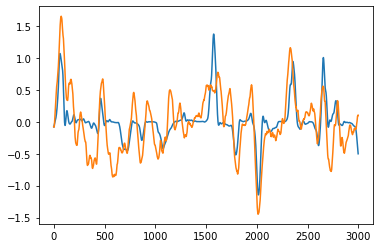

In [25]:
plt.plot(state[3, training_size:training_size+3000], label='True')
plt.plot(ukf_predict[3, :], label='UKF')

In [49]:
X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(data_path, SESS_IDX)
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))
neural, states, bin_stops_t = get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1)
neural = np.squeeze(neural).T
state = states[:, :4].T

# Seperating training and test samples
training_size = 5000

state_train = state[:, :training_size]
neural_train = neural[:, :training_size]
state_test = state[:, training_size:]
neural_test = neural[:, training_size:]

# Initialize predicted states
kf_predict = np.zeros((4, 3000))

# Instantiating from KF class
mykf = ManualKalmanFilter(x=state_train, z = neural_train)

# Looping through test data
rng = 3000
for i in range(rng):
    mykf.predict()
    neural_in = neural_test[:,i]
    kf_predict[:, i] = np.reshape(mykf.update(neural_in), (mykf.m, ))
    if i%200 == 0:
        print('KF - Step: ' + str(i) + ' out of ' + str(rng))
print('KF Finished')

KF - Step: 0 out of 3000
KF - Step: 200 out of 3000
KF - Step: 400 out of 3000
KF - Step: 600 out of 3000
KF - Step: 800 out of 3000
KF - Step: 1000 out of 3000
KF - Step: 1200 out of 3000
KF - Step: 1400 out of 3000
KF - Step: 1600 out of 3000
KF - Step: 1800 out of 3000
KF - Step: 2000 out of 3000
KF - Step: 2200 out of 3000
KF - Step: 2400 out of 3000
KF - Step: 2600 out of 3000
KF - Step: 2800 out of 3000
KF Finished


In [52]:
state.shape

(4, 89975)

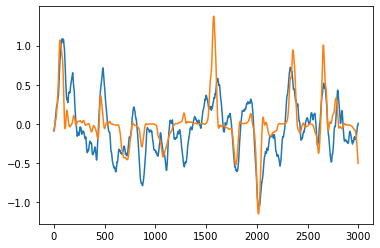

In [56]:
plt.plot(kf_predict[3,:])
plt.plot(state[3,5000:8000])

In [9]:
X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(data_path, SESS_IDX)
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))
neural, states, bin_stops_t = get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1)
neural = np.squeeze(neural)
state = states[:, :4].T

print(neural.shape, states.shape)

(89975, 88) (89975, 6)


In [11]:
[1:5]

SyntaxError: invalid syntax (<ipython-input-11-995aa0130b62>, line 1)

In [12]:
x_train = neural[:4000, :]
y_train_vx = states[:4000, 2]
y_train_vy = states[:4000, 3]
x_test = neural[4000:, :]
y_test_vx = states[4000:, 2]
y_test_vy = states[4000:, 3]

regressor = SVC(verbose=1).fit(x_train, y_train_vx)
pred = regressor.predict(x_test)

ValueError: Unknown label type: 'continuous'